## Clustering

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn

from sklearn.utils import check_random_state
from sklearn.cluster import KMeans

from nose.tools import assert_equal, assert_is_instance, assert_true, assert_is_not
from numpy.testing import assert_array_equal, assert_array_almost_equal, assert_almost_equal

In [2]:
reduced = np.load('delta_reduced.npy')

### k-means

In [3]:
def cluster(array, random_state, n_clusters=4):
    '''
    Fits and predicts k-means clustering on "array"
    
    Parameters
    ----------
    array: A numpy array
    random_state: Random seed, e.g. check_random_state(0)
    n_clusters: The number of clusters. Default: 4
    
    Returns
    -------
    A tuple (sklearn.KMeans, np.ndarray)
    '''
    
    k_means = KMeans(n_clusters=n_clusters,random_state=random_state)
    k_means.fit(array)
    y_pred = k_means.predict(array)
    return k_means, y_pred

In [4]:
k_means_t, cluster_t = cluster(reduced, random_state=check_random_state(1), n_clusters=5)

assert_is_instance(k_means_t, sklearn.cluster.k_means_.KMeans)
assert_is_instance(cluster_t, np.ndarray)
assert_equal(k_means_t.n_init, 10)
assert_equal(k_means_t.n_clusters, 5)
assert_equal(len(cluster_t), len(reduced))
assert_true((cluster_t < 5).all()) # n_cluster = 5 so labels should be between 0 and 5
assert_true((cluster_t >= 0).all())
labels_gold = -1. * np.ones(len(reduced), dtype=np.int)
mindist = np.empty(len(reduced))
mindist.fill(np.infty)
for i in range(5):
    dist = np.sum((reduced - k_means_t.cluster_centers_[i])**2., axis=1)
    labels_gold[dist < mindist] = i
    mindist = np.minimum(dist, mindist)
assert_true((mindist >= 0.0).all())
assert_true((labels_gold != -1).all())
assert_array_equal(labels_gold, cluster_t)

### The elbow method

In [7]:
def plot_inertia(array, start=1, end=10):
    '''
    Increase the number of clusters from "start" to "end" (inclusive).
    Finds the inertia of k-means clustering for different k.
    Plots inertia as a function of the number of clusters.

    
    Parameters
    ----------
    array: A numpy array.
    start: An int. Default: 1
    end: An int. Default: 10
    
    Returns
    -------
    A matplotlib.Axes instance.
    '''
    
    result=[]
    for i in range(start, end+1):
        k_means=cluster(array, random_state=check_random_state(0), n_clusters=i)[0]
        inta=k_means.inertia_ 
        result.append(inta)
    fig, ax = plt.subplots(figsize=(10,6))
    sns.set(style="ticks", font_scale=2.0)
    plt.plot(np.arange(start, end+1, 1),result)
    ax.set_xlabel('Number of clusters')
    ax.set_ylabel('Inertia')
    ax.set_title('The elbow method')
    ax.set_xlim(1, 10)
    ax.set_ylim(0, 1600)
    return ax

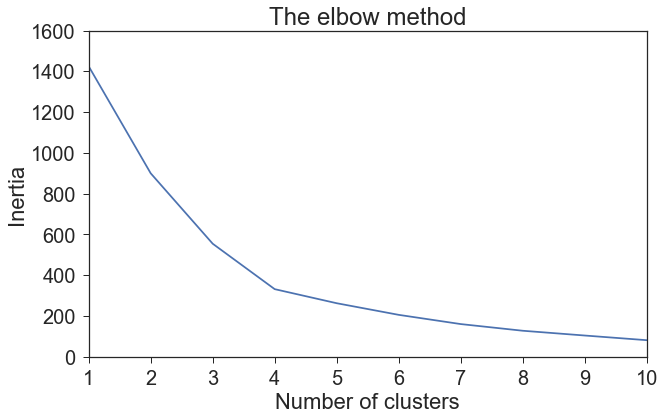

In [8]:
inertia = plot_inertia(reduced)

In [9]:
assert_is_instance(inertia, mpl.axes.Axes)
assert_true(len(inertia.lines) >= 1)

xdata, ydata = inertia.lines[0].get_xydata().T

for i in range(1, 11):
    k_means_t, cluster_t = cluster(reduced, random_state=check_random_state(0), n_clusters=i)
    assert_array_equal(xdata[i - 1], i)
    assert_almost_equal(ydata[i - 1], k_means_t.inertia_)

assert_is_not(len(inertia.title.get_text()), 0,
    msg="Your plot doesn't have a title.")
assert_is_not(inertia.xaxis.get_label_text(), '',
    msg="Change the x-axis label to something more descriptive.")
assert_is_not(inertia.yaxis.get_label_text(), '',
    msg="Change the y-axis label to something more descriptive.")

### Pair Grid

In [202]:
def plot_pair(reduced, clusters):
    '''
    Uses seaborn.PairGrid to visualize the data distribution
    when axes are the first four principal components.
    Diagonal plots are histograms. The off-diagonal plots are scatter plots.
    
    Parameters
    ----------
    reduced: A numpy array. Comes from importing delta_reduced.npy
    
    Returns
    -------
    A seaborn.axisgrid.PairGrid instance.
    '''
    
    new=pd.DataFrame(reduced).iloc[:,0:4]
    new.columns=['PCA1','PCA2','PCA3','PCA4']
    cls=pd.DataFrame(clusters,columns=['type'])
    ncls=pd.concat([new,cls],axis=1)
    ax=sns.PairGrid(ncls, vars=['PCA1','PCA2','PCA3','PCA4'], hue="type")
    ax.map_diag(plt.hist)
    ax.map_offdiag(plt.scatter)
    return ax

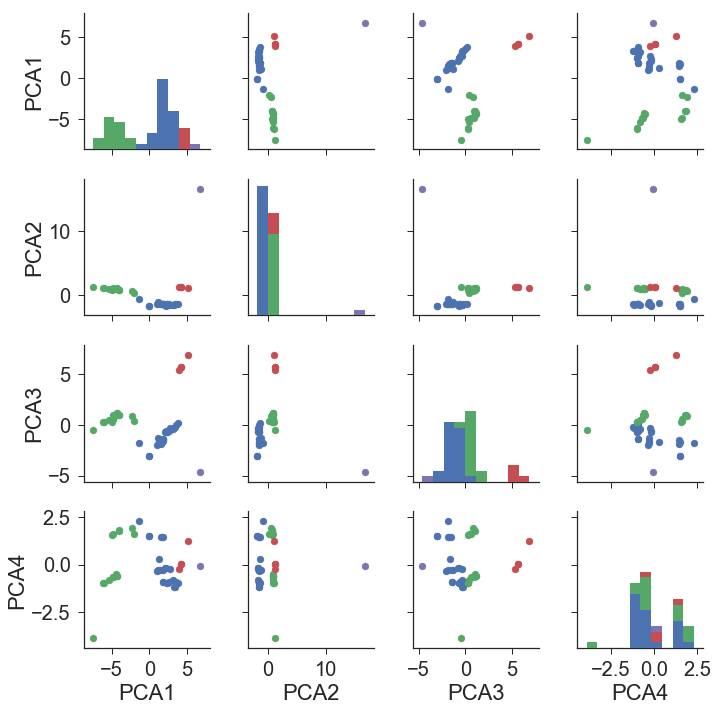

In [203]:
k_means, clusters = cluster(reduced, random_state=check_random_state(0), n_clusters=4)
pg = plot_pair(reduced, clusters)

In [204]:
assert_is_instance(pg.fig, plt.Figure)
assert_true(len(pg.data.columns) >= 4)

for ax in pg.diag_axes:
    assert_equal(len(ax.patches), 4 * 10) # 4 clusters with 10 patches in each histogram

for i, j in zip(*np.triu_indices_from(pg.axes, 1)):
    ax = pg.axes[i, j]
    x_out, y_out = ax.collections[0].get_offsets().T
    x_in = reduced[clusters == 0, j] # we only check the first cluster
    y_in = reduced[clusters == 0, i]
    assert_array_equal(x_in, x_out)
    assert_array_equal(y_in, y_out)

for i, j in zip(*np.tril_indices_from(pg.axes, -1)):
    ax = pg.axes[i, j]
    x_in = reduced[clusters == 0, j]
    y_in = reduced[clusters == 0, i]
    x_out, y_out = ax.collections[0].get_offsets().T
    assert_array_equal(x_in, x_out)
    assert_array_equal(y_in, y_out)

for i, j in zip(*np.diag_indices_from(pg.axes)):
    ax = pg.axes[i, j]
    assert_equal(len(ax.collections), 0)

### More discussion

In [205]:
df = pd.read_csv('delta.csv', index_col='Aircraft')
df['Clusters'] = clusters
df['Aircraft'] = df.index
df_grouped = df.groupby('Clusters').mean()
print(df_grouped.Accommodation)

Clusters
0    153.625000
1    244.733333
2     44.500000
3     54.000000
Name: Accommodation, dtype: float64


In [206]:
print(df_grouped['Length (ft)'])

Clusters
0    137.048083
1    190.538400
2     84.810750
3    111.000000
Name: Length (ft), dtype: float64


In [207]:
clust3 = df[df.Clusters == 3]
print(clust3.Aircraft)

Aircraft
Airbus A319 VIP    Airbus A319 VIP
Name: Aircraft, dtype: object


In [208]:
clust2 = df[df.Clusters == 2]
print(clust2.Aircraft)

Aircraft
CRJ 100/200 Pinnacle/SkyWest    CRJ 100/200 Pinnacle/SkyWest
CRJ 100/200 ExpressJet                CRJ 100/200 ExpressJet
E120                                                    E120
ERJ-145                                              ERJ-145
Name: Aircraft, dtype: object


In [209]:
cols_seat = ['First Class', 'Business', 'Eco Comfort', 'Economy']
print(df.loc[clust2.index, cols_seat])

                              First Class  Business  Eco Comfort  Economy
Aircraft                                                                 
CRJ 100/200 Pinnacle/SkyWest            0         0            0        1
CRJ 100/200 ExpressJet                  0         0            0        1
E120                                    0         0            0        1
ERJ-145                                 0         0            0        1


In [210]:
clust1 = df[df.Clusters == 1]
print(clust1.Aircraft)

Aircraft
Airbus A330-200                      Airbus A330-200
Airbus A330-200 (3L2)          Airbus A330-200 (3L2)
Airbus A330-200 (3L3)          Airbus A330-200 (3L3)
Airbus A330-300                      Airbus A330-300
Boeing 747-400 (74S)            Boeing 747-400 (74S)
Boeing 757-200 (75E)            Boeing 757-200 (75E)
Boeing 757-200 (75X)            Boeing 757-200 (75X)
Boeing 767-300 (76G)            Boeing 767-300 (76G)
Boeing 767-300 (76L)            Boeing 767-300 (76L)
Boeing 767-300 (76T)            Boeing 767-300 (76T)
Boeing 767-300 (76Z V.1)    Boeing 767-300 (76Z V.1)
Boeing 767-300 (76Z V.2)    Boeing 767-300 (76Z V.2)
Boeing 767-400 (76D)            Boeing 767-400 (76D)
Boeing 777-200ER                    Boeing 777-200ER
Boeing 777-200LR                    Boeing 777-200LR
Name: Aircraft, dtype: object


In [211]:
print(df.loc[clust1.index, cols_seat])

                          First Class  Business  Eco Comfort  Economy
Aircraft                                                             
Airbus A330-200                     0         1            1        1
Airbus A330-200 (3L2)               0         1            1        1
Airbus A330-200 (3L3)               0         1            1        1
Airbus A330-300                     0         1            1        1
Boeing 747-400 (74S)                0         1            1        1
Boeing 757-200 (75E)                0         1            1        1
Boeing 757-200 (75X)                0         1            1        1
Boeing 767-300 (76G)                0         1            1        1
Boeing 767-300 (76L)                0         1            1        1
Boeing 767-300 (76T)                0         1            1        1
Boeing 767-300 (76Z V.1)            0         1            1        1
Boeing 767-300 (76Z V.2)            0         1            1        1
Boeing 767-400 (76D)

In [212]:
clust0 = df[df.Clusters == 0]
print(clust0.Aircraft)

Aircraft
Airbus A319                          Airbus A319
Airbus A320                          Airbus A320
Airbus A320 32-R                Airbus A320 32-R
Boeing 717                            Boeing 717
Boeing 737-700 (73W)        Boeing 737-700 (73W)
Boeing 737-800 (738)        Boeing 737-800 (738)
Boeing 737-800 (73H)        Boeing 737-800 (73H)
Boeing 737-900ER (739)    Boeing 737-900ER (739)
Boeing 757-200 (75A)        Boeing 757-200 (75A)
Boeing 757-200 (75M)        Boeing 757-200 (75M)
Boeing 757-200 (75N)        Boeing 757-200 (75N)
Boeing 757-200 (757)        Boeing 757-200 (757)
Boeing 757-200 (75V)        Boeing 757-200 (75V)
Boeing 757-300                    Boeing 757-300
Boeing 767-300 (76P)        Boeing 767-300 (76P)
Boeing 767-300 (76Q)        Boeing 767-300 (76Q)
Boeing 767-300 (76U)        Boeing 767-300 (76U)
CRJ 700                                  CRJ 700
CRJ 900                                  CRJ 900
E170                                        E170
E175       

In [213]:
print(df.loc[clust0.index, cols_seat])

                        First Class  Business  Eco Comfort  Economy
Aircraft                                                           
Airbus A319                       1         0            1        1
Airbus A320                       1         0            1        1
Airbus A320 32-R                  1         0            1        1
Boeing 717                        1         0            1        1
Boeing 737-700 (73W)              1         0            1        1
Boeing 737-800 (738)              1         0            1        1
Boeing 737-800 (73H)              1         0            1        1
Boeing 737-900ER (739)            1         0            1        1
Boeing 757-200 (75A)              1         0            1        1
Boeing 757-200 (75M)              1         0            1        1
Boeing 757-200 (75N)              1         0            1        1
Boeing 757-200 (757)              1         0            1        1
Boeing 757-200 (75V)              1         0   